<div style="
    padding: 20px;
    color: white;
    margin: 0;
    font-size: 300%;
    font-weight: 800;
    text-align: center;
    display: fill;
    border-radius: 60px;
    background-color: #CC99FF;
    box-shadow: 0 4px 8px rgba(0, 0, 0, 0.2);
    text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.5);
">
    Historical Weather Data for 2020
</div>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/historical-weather-data-for-2020/historical_weather_data.csv


# Project. Historical Weather Data for 2020
## Goal
> ## EDA : Column Analysis, Column Correlation Analysis, Time series analysis
> ## Modeling : Predicting Outcome

# Import Libraries & Read Dataset

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
# For EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.inspection import permutation_importance
import itertools

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# For Machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# For Deep learning
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, Embedding, LSTM, GRU, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam

In [4]:
df = pd.read_csv('/kaggle/input/historical-weather-data-for-2020/historical_weather_data.csv')
df

,Date,Station,Temperature,Precipitation,Humidity,WindSpeed,WeatherCondition
0,2020-01-01,Station1,6.653288,0.000000,64.421750,9.562955,Partly Cloudy
1,2020-01-02,Station1,-2.031372,2.988470,85.492843,6.502074,Cloudy
2,2020-01-03,Station1,-6.428333,0.000000,90.456869,3.486873,Snow
3,2020-01-04,Station1,31.471383,0.000000,98.352442,17.288559,Partly Cloudy
4,2020-01-05,Station1,34.220877,0.000000,89.589972,12.807424,Snow
...,...,...,...,...,...,...,...
1090,2020-12-26,Station3,-0.835253,0.000000,65.076321,0.019720,Partly Cloudy
1091,2020-12-27,Station3,2.919267,2.618100,96.340605,1.038474,Partly Cloudy
1092,2020-12-28,Station3,9.629670,5.394643,93.535156,13.220947,Partly Cloudy
1093,2020-12-29,Station3,14.746835,9.947806,34.957432,17.892623,Rain


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              1095 non-null   object 
 1   Station           1095 non-null   object 
 2   Temperature       1095 non-null   float64
 3   Precipitation     1095 non-null   float64
 4   Humidity          1095 non-null   float64
 5   WindSpeed         1095 non-null   float64
 6   WeatherCondition  1095 non-null   object 
dtypes: float64(4), object(3)
memory usage: 60.0+ KB


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Temperature,1095.0,12.378222,12.999715,-9.917431,1.011684,11.848181,23.943024,34.801968
Precipitation,1095.0,1.704898,2.882439,0.000000,0.000000,0.000000,2.716680,9.981918
Humidity,1095.0,65.686983,20.053421,30.080449,48.814778,65.515553,83.111551,99.982887
WindSpeed,1095.0,9.826464,5.864450,0.002290,4.928115,9.752793,14.669068,19.996688


# EDA : Column Analysis

In [7]:
df['Date'] = pd.to_datetime(df['Date'])

col_name_object = df.select_dtypes(include='object').columns.tolist()
col_name_num = df.select_dtypes(include=['float64','int64']).columns.tolist()
time_series = ['Year', 'Month','Date']

for col in col_name_object:
    print(f"Column '{col}' unquie values: {df[col].unique()}")

Column 'Station' unquie values: ['Station1' 'Station2' 'Station3']
Column 'WeatherCondition' unquie values: ['Partly Cloudy' 'Cloudy' 'Snow' 'Rain' 'Sunny']


In [8]:
 fig = go.Figure()

for col in col_name_num:
    fig = go.Figure()
    fig.add_trace(go.Box(y=df[col], name=col))

    fig.update_layout(
        title=f"Box Plot for {col}",
        yaxis_title="Values",
        title_font_size=25,
        plot_bgcolor='black',
        paper_bgcolor='black',
        font=dict(color='white')
    )

    fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='white', griddash='dash')
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='white', griddash='dash')

    fig.show()

# EDA : Column Correlation Analysis

In [9]:
X = df.drop(columns=['WeatherCondition','Date'])
y = df['WeatherCondition']

X_encoded = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)

coefficients = model.coef_[0]
feature_names = X_encoded.columns

print("Feature Coefficients:")
for feature_name, coef in zip(feature_names, coefficients):
    print(f"{feature_name}: {coef:.5f}")

Feature Coefficients:
Temperature: 0.00779
Precipitation: 0.03889
Humidity: -0.00057
WindSpeed: -0.01812
Station_Station1: -0.12505
Station_Station2: -0.44899
Station_Station3: -0.37292


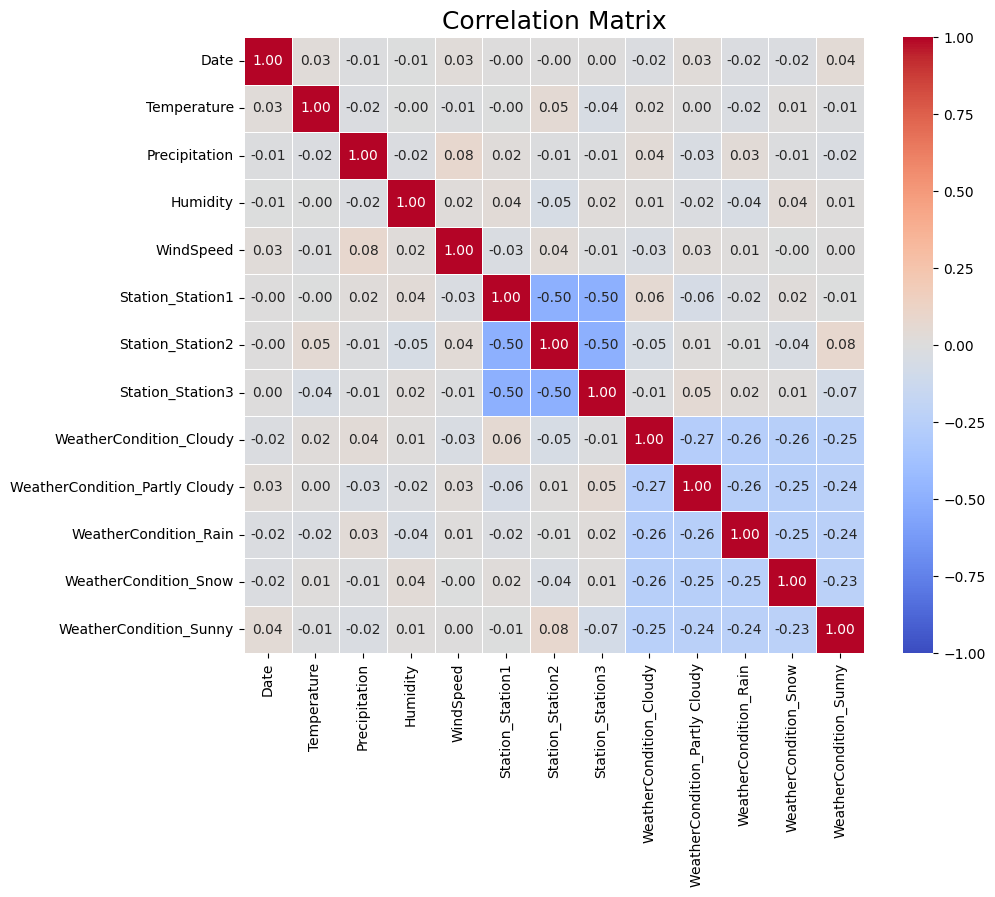

In [10]:
df_encoded = pd.get_dummies(df)
correlation_matrix = df_encoded.corr().round(3)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5, fmt='.2f', vmin=-1, vmax=1)

plt.title('Correlation Matrix', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=10, labelcolor='black')

plt.show()

# EDA : Time series analysis & Charts

In [11]:
selected_columns = col_name_num + ['Date']
df_numeric = df[selected_columns] 
mean_values_by_date = df_numeric.groupby('Date').mean()

colors = ['blue', 'green', 'yellow', 'orange']  

for i, col in enumerate(mean_values_by_date.columns):
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=mean_values_by_date.index,
        y=mean_values_by_date[col],
        mode='lines',
        name=col,
        line=dict(color=colors[i % len(colors)]) 
    ))

    fig.update_layout(
        title=f'Mean Time Series Plot for {col}',
        xaxis_title='Date',
        yaxis_title='Mean Values',
        title_font_size=25,
        plot_bgcolor='black',
        paper_bgcolor='black',
        font=dict(color='white')
    )

    fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='white', griddash='dash')
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='white', griddash='dash')

    fig.show()

In [12]:
selected_columns = col_name_num + ['WeatherCondition']
df_numeric = df[selected_columns] 
mean_values_by_condition = df_numeric.groupby('WeatherCondition').mean()


colors = ['#7b3294',  
          '#2c7fb8',  
          '#fdae61',  
          '#abd9e9' ]

for i, condition in enumerate(mean_values_by_condition.index):
    fig = go.Figure()
    
    for j, col in enumerate(mean_values_by_condition.columns):  
        fig.add_trace(go.Bar(
            x=[col],
            y=[mean_values_by_condition.loc[condition, col]],
            name=col,
            marker_color=colors[j % len(colors)]  
        ))
    
    fig.update_layout(
        title=f'Mean Weather Metrics for {condition}',
        xaxis_title='Metrics',
        yaxis_title='Mean Values',
        title_font_size=25,
        plot_bgcolor='black',
        paper_bgcolor='black',
        font=dict(color='white'),
        legend=dict(font=dict(color='white'))
    )
    
    fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='white', griddash='dash')
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='white', griddash='dash')
    
    fig.show()

In [13]:
df['Month'] = df['Date'].dt.strftime('%Y-%m')  

selected_columns = ['Temperature', 'Precipitation', 'Humidity', 'WindSpeed', 'WeatherCondition', 'Month']
df_numeric = df[selected_columns]

mean_values_by_condition_month = df_numeric.groupby(['WeatherCondition', 'Month']).mean().reset_index()

colors = {
    'Temperature': '#7b3294',  
    'Precipitation': '#2c7fb8',  
    'Humidity': '#fdae61',  
    'WindSpeed': '#abd9e9'  
}

for condition in mean_values_by_condition_month['WeatherCondition'].unique():
    fig = go.Figure()
    
    for metric in ['Temperature', 'Precipitation', 'Humidity', 'WindSpeed']:
        subset = mean_values_by_condition_month[(mean_values_by_condition_month['WeatherCondition'] == condition)]
        fig.add_trace(go.Bar(
            x=subset['Month'],
            y=subset[metric],
            name=metric,
            marker_color=colors[metric]
        ))
    
    fig.update_layout(
        title=f'Mean Weather Metrics for {condition} (Monthly)',
        xaxis_title='Month',
        yaxis_title='Mean Values',
        title_font_size=25,
        plot_bgcolor='black',
        paper_bgcolor='black',
        font=dict(color='white'),
        legend=dict(font=dict(color='white'))
    )
    
    fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='white', griddash='dash')
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='white', griddash='dash')
    
    fig.show()

In [14]:
fig = px.parallel_coordinates(df, 
                              color='Temperature',  
                              dimensions=['Temperature', 'Precipitation', 'Humidity', 'WindSpeed'],
                              labels={'Temperature': 'Temperature (°C)', 
                                      'Precipitation': 'Precipitation (mm)',
                                      'Humidity': 'Humidity (%)',
                                      'WindSpeed': 'Wind Speed (km/h)',
                                      'WeatherCondition': 'Weather Condition'})

fig.update_layout(
    title='Parallel Coordinates Plot for Weather Metrics',
    plot_bgcolor='black',
    paper_bgcolor='black',
    font=dict(color='white'),
    legend=dict(font=dict(color='white')),
    margin=dict(t=120)  
)

fig.show()

# Machine learning

In [15]:
def evaluate_models(X, y):

    categorical_columns = X.select_dtypes(include=['object']).columns.tolist()
    numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

    encoder = OneHotEncoder(drop='first', sparse=False)
    X_categorical = pd.DataFrame(encoder.fit_transform(X[categorical_columns]))

    scaler = StandardScaler()
    X_numerical = pd.DataFrame(scaler.fit_transform(X[numerical_columns]))

    X_processed = pd.concat([X_categorical, X_numerical], axis=1)

    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    
    X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

    models = [
        ('Logistic Regression', LogisticRegression()),   
        ('Decision Tree Classifier', DecisionTreeClassifier()),
        ('Random Forest Classifier', RandomForestClassifier()),
        ('Support Vector Classifier', SVC()),
        ('K-Nearest Neighbors Classifier', KNeighborsClassifier()),
        ('XGBoost Classifier', XGBClassifier()),
        ('LightGBM Classifier', LGBMClassifier())
    ]

    results = {}
    for name, model in models:
        pipeline = Pipeline([('scaler', StandardScaler()), (name, model)])
        
        pipeline.fit(X_train, y_train)
        
        y_pred = pipeline.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        
        results[name] = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1
        }

    results_df = pd.DataFrame.from_dict(results, orient='index').reset_index()
    results_df.rename(columns={'index': 'Model'}, inplace=True)

    return results_df

In [16]:
X = df.drop(columns = ['WeatherCondition','Month'])
y = df['WeatherCondition']

evaluate_models(X, y)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000995 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 873
[LightGBM] [Info] Number of data points in the train set: 876, number of used features: 6
[LightGBM] [Info] Start training from score -1.549619
[LightGBM] [Info] Start training from score -1.587980
[LightGBM] [Info] Start training from score -1.576869
[LightGBM] [Info] Start training from score -1.651402
[LightGBM] [Info] Start training from score -1.687770


,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.173516,0.135588,0.173516,0.150390
1,Decision Tree Classifier,0.191781,0.190794,0.191781,0.189462
2,Random Forest Classifier,0.191781,0.190881,0.191781,0.190993
3,Support Vector Classifier,0.182648,0.175648,0.182648,0.176051
4,K-Nearest Neighbors Classifier,0.168950,0.169519,0.168950,0.163232
5,XGBoost Classifier,0.228311,0.232874,0.228311,0.228099
6,LightGBM Classifier,0.196347,0.197770,0.196347,0.196015


# Deep learning

In [17]:
encoder = LabelEncoder()
df['WeatherCondition'] = encoder.fit_transform(df['WeatherCondition'])

df['Year'] = pd.to_datetime(df['Date']).dt.year
df['Month'] = pd.to_datetime(df['Date']).dt.month
df['Day'] = pd.to_datetime(df['Date']).dt.day

X = df[['Year', 'Month', 'Day', 'Temperature', 'Precipitation', 'Humidity', 'WindSpeed']]
y = df['WeatherCondition']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

> # 1. ANN (Artificial Neural Network)

In [18]:
model_ANN = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_ANN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

history = model_ANN.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
 1/22 ━━━━━━━━━━━━━━━━━━━━ 1:47 5s/step - accuracy: 0.2812 - loss: 1.7084

I0000 00:00:1719550101.058016      79 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 182ms/step - accuracy: 0.2124 - loss: 1.3108 - val_accuracy: 0.2045 - val_loss: 0.1333
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2150 - loss: -0.0118 - val_accuracy: 0.1989 - val_loss: -0.7709
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2218 - loss: -0.9190 - val_accuracy: 0.1989 - val_loss: -1.8033
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2028 - loss: -1.9417 - val_accuracy: 0.1989 - val_loss: -3.1119
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2033 - loss: -3.5293 - val_accuracy: 0.1989 - val_loss: -4.9125
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2096 - loss: -5.7569 - val_accuracy: 0.1989 - val_loss: -7.4115
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1921 - loss: -6.9848 - val_accuracy: 0.1989 - val_loss: -10.5656
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1890 - loss: -11.8341 - val_accuracy: 0.198

In [19]:
y_pred = (model_ANN.predict(X_test_scaled) > 0.5).astype(int)
print(classification_report(y_test, y_pred,target_names=['Partly Cloudy', 'Cloudy', 'Snow', 'Rain', 'Sunny'], zero_division=1))

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step
               precision    recall  f1-score   support

Partly Cloudy       1.00      0.00      0.00        48
       Cloudy       0.22      1.00      0.37        49
         Snow       1.00      0.00      0.00        39
         Rain       1.00      0.00      0.00        46
        Sunny       1.00      0.00      0.00        37

     accuracy                           0.22       219
    macro avg       0.84      0.20      0.07       219
 weighted avg       0.83      0.22      0.08       219



> # 2. RNN (Recurrent Neural Network)

In [20]:
X_train_rnn = pad_sequences(X_train.values, maxlen=10)
X_test_rnn = pad_sequences(X_test.values, maxlen=10)

In [21]:
model_RNN = Sequential([
    Embedding(input_dim=10, output_dim=64),
    SimpleRNN(units=32, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

model_RNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_RNN.fit(X_train_rnn, y_train, epochs=10, batch_size=32, validation_data=(X_test_rnn, y_test))

Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.2075 - loss: -1.2086 - val_accuracy: 0.2237 - val_loss: -34.5446
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2098 - loss: -377.6942 - val_accuracy: 0.2237 - val_loss: -8412.7646
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1859 - loss: -70641.4375 - val_accuracy: 0.2237 - val_loss: -1162248.1250
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2287 - loss: -6581999.0000 - val_accuracy: 0.2237 - val_loss: -76549184.0000
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2064 - loss: -296717184.0000 - val_accuracy: 0.2237 - val_loss: -2458919936.0000
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2067 - loss: -7446957056.0000 - val_accuracy: 0.2237 - val_loss: -47216623616.0000
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1982 - loss: -114700992512.0000 - val_accuracy: 0.2237 - val_loss: -586766024704.0000
Epoch 8/10
28/28

In [22]:
y_pred = model_RNN.predict(X_test_rnn)
y_pred_binary = (y_pred > 0.5).astype(int)  

print(classification_report(y_test, y_pred,target_names=['Partly Cloudy', 'Cloudy', 'Snow', 'Rain', 'Sunny'], zero_division=1))

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
               precision    recall  f1-score   support

Partly Cloudy       1.00      0.00      0.00        48
       Cloudy       0.22      1.00      0.37        49
         Snow       1.00      0.00      0.00        39
         Rain       1.00      0.00      0.00        46
        Sunny       1.00      0.00      0.00        37

     accuracy                           0.22       219
    macro avg       0.84      0.20      0.07       219
 weighted avg       0.83      0.22      0.08       219



> # 3. LSTM (Long Short-Term Memory)

In [23]:
X_train_array = X_train.values
X_test_array = X_test.values

X_train_lstm = X_train_array.reshape((X_train_array.shape[0], 1, X_train_array.shape[1]))
X_test_lstm = X_test_array.reshape((X_test_array.shape[0], 1, X_test_array.shape[1]))


model_LSTM = Sequential([
    Input(shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])), 
    LSTM(64, activation='relu'), 
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  
])

model_LSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_LSTM.fit(X_train_lstm, y_train, epochs=50, batch_size=32, validation_data=(X_test_lstm, y_test))

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - accuracy: 0.1967 - loss: 70.0802 - val_accuracy: 0.2237 - val_loss: -82.8530
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2275 - loss: -123.9126 - val_accuracy: 0.2237 - val_loss: -220.8919
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1944 - loss: -327.5500 - val_accuracy: 0.2237 - val_loss: -482.3408
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2077 - loss: -707.1080 - val_accuracy: 0.2237 - val_loss: -1069.2360
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2068 - loss: -1346.4340 - val_accuracy: 0.2237 - val_loss: -2220.0190
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2130 - loss: -2993.9019 - val_accuracy: 0.2237 - val_loss: -4346.1694
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1938 - loss: -5439.6846 - val_accuracy: 0.2237 - val_loss: -7581.7354
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1992 

In [24]:
y_pred = model_LSTM.predict(X_test_lstm)
y_pred_binary = (y_pred > 0.5).astype(int)  

print(classification_report(y_test, y_pred,target_names=['Partly Cloudy', 'Cloudy', 'Snow', 'Rain', 'Sunny'], zero_division=1))

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step
               precision    recall  f1-score   support

Partly Cloudy       1.00      0.00      0.00        48
       Cloudy       0.22      1.00      0.37        49
         Snow       1.00      0.00      0.00        39
         Rain       1.00      0.00      0.00        46
        Sunny       1.00      0.00      0.00        37

     accuracy                           0.22       219
    macro avg       0.84      0.20      0.07       219
 weighted avg       0.83      0.22      0.08       219



> # 4. GRU (Gated Recurrent Unit) 

In [25]:
X_train_gru = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_gru = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

inputs = Input(shape=(X_train_gru.shape[1], X_train_gru.shape[2]))

gru_layer = GRU(50, activation='relu')(inputs)
outputs = Dense(1, activation='sigmoid')(gru_layer)

model_GRU = Model(inputs=inputs, outputs=outputs)
model_GRU.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_gru = model_GRU.fit(X_train_gru, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.2017 - loss: 0.5251 - val_accuracy: 0.1989 - val_loss: 0.0471
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2113 - loss: -0.1106 - val_accuracy: 0.1989 - val_loss: -1.4604
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2082 - loss: -3.3660 - val_accuracy: 0.1989 - val_loss: -41.0985
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1803 - loss: -185.4116 - val_accuracy: 0.1989 - val_loss: -2227.0730
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1973 - loss: -6416.8506 - val_accuracy: 0.1989 - val_loss: -53336.2969
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2002 - loss: -118076.7109 - val_accuracy: 0.1989 - val_loss: -701499.0000
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2189 - loss: -1255529.1250 - val_accuracy: 0.1989 - val_loss: -5791135.0000
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1885 

In [26]:
y_pred = model_GRU.predict(X_test_gru)
y_pred_binary = (y_pred > 0.5).astype(int)  

print(classification_report(y_test, y_pred,target_names=['Partly Cloudy', 'Cloudy', 'Snow', 'Rain', 'Sunny'], zero_division=1))

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step
               precision    recall  f1-score   support

Partly Cloudy       1.00      0.00      0.00        48
       Cloudy       0.22      1.00      0.37        49
         Snow       1.00      0.00      0.00        39
         Rain       1.00      0.00      0.00        46
        Sunny       1.00      0.00      0.00        37

     accuracy                           0.22       219
    macro avg       0.84      0.20      0.07       219
 weighted avg       0.83      0.22      0.08       219



> # 5. MLP (Multi-Layer Perceptron)

In [27]:
model_MLP = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1)  
])

model_MLP.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_MLP.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_data=(X_test_scaled, y_test))

Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - accuracy: 0.2148 - loss: nan - val_accuracy: 0.2192 - val_loss: nan
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2170 - loss: nan - val_accuracy: 0.2192 - val_loss: nan
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2144 - loss: nan - val_accuracy: 0.2192 - val_loss: nan
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2081 - loss: nan - val_accuracy: 0.2192 - val_loss: nan
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2113 - loss: nan - val_accuracy: 0.2192 - val_loss: nan
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2140 - loss: nan - val_accuracy: 0.2192 - val_loss: nan
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2354 - loss: nan - val_accuracy: 0.2192 - val_loss: nan
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2002 - loss: nan - val_accuracy: 0.2192 - val_loss: nan
Epoch 9/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 

In [28]:
y_pred = model_MLP.predict(X_test_scaled)
y_pred_classes = y_pred.argmax(axis=-1)

print(classification_report(y_test, y_pred_classes,target_names=['Partly Cloudy', 'Cloudy', 'Snow', 'Rain', 'Sunny'], zero_division=1))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
               precision    recall  f1-score   support

Partly Cloudy       0.22      1.00      0.36        48
       Cloudy       1.00      0.00      0.00        49
         Snow       1.00      0.00      0.00        39
         Rain       1.00      0.00      0.00        46
        Sunny       1.00      0.00      0.00        37

     accuracy                           0.22       219
    macro avg       0.84      0.20      0.07       219
 weighted avg       0.83      0.22      0.08       219



# Thanks